In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
random_state = 42
import autoreload
%load_ext autoreload
%autoreload 2
import python_code.Scripts as sc
import python_code.Reference as ref
import pickle

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score
import treeinterpreter as ti
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv("./data/final.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   REALPROP  3904 non-null   float64
 1   FSASSET   3904 non-null   float64
 2   FSSSI     3904 non-null   float64
 3   FSNELDER  3904 non-null   float64
 4   TANF_IND  3904 non-null   float64
 5   FSUSIZE   3904 non-null   float64
 6   FSEARN    3904 non-null   float64
 7   FSWAGES   3904 non-null   float64
 8   RAWNET    3904 non-null   float64
 9   FSSLTDE2  3904 non-null   float64
 10  FSSTDDE2  3904 non-null   float64
 11  FSTOTDED  3904 non-null   float64
 12  FSNONCIT  3904 non-null   float64
 13  FSSLTDED  3904 non-null   float64
 14  WRK_POOR  3904 non-null   float64
 15  LIQRESOR  3904 non-null   float64
 16  RAWERND   3904 non-null   float64
 17  TPOV      3904 non-null   float64
 18  FSGRINC   3904 non-null   float64
 19  HWGT      3904 non-null   float64
 20  FSERNDED  3904 non-null   floa

In [4]:
X = df.drop(columns = ['CAT_ELIG'])
y = df['CAT_ELIG']

In [5]:
#baseline, NULL Model
y.value_counts(normalize=True)

1.0    0.662398
0.0    0.337602
Name: CAT_ELIG, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=random_state)

In [7]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:
np.savetxt('./data/TrainTest/X_train.csv',X_train,delimiter=',')
np.savetxt('./data/TrainTest/y_train.csv',y_train,delimiter=',')
np.savetxt('./data/TrainTest/X_test.csv',X_test,delimiter=',')
np.savetxt('./data/TrainTest/y_test.csv',y_test,delimiter=',')

In [9]:
pca = PCA(n_components=10,random_state=42)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

In [10]:
models = {
    'LogReg': LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(),
    'Gradient Boost':GradientBoostingClassifier(),
    'Ada Boost':AdaBoostClassifier(),
    'SVC':SVC(),
    'Naive Bayes':GaussianNB()}

In [11]:
#adapted from Dan Brown lecture
final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        final = final.append(results,ignore_index=True)
        idx+=1

In [12]:
final.set_index('name')

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.884334,0.862628,0.900262,0.903821
Decision Tree,0.906296,0.909556,0.937008,0.932115
Random Forest,0.942167,0.928328,0.960630,0.960630
Gradient Boost,0.940703,0.930034,0.950131,0.960212
Ada Boost,0.922035,0.920648,0.937008,0.939474
SVC,0.884700,0.854949,0.901575,0.928378
Naive Bayes,0.767204,0.741468,0.833333,0.908441


In [13]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)
y_pred_train = bag.predict(X_train)
y_pred_test = bag.predict(X_test)
print(f'cross_val_train = {np.mean(cross_val_score(model,X_train,y_train,cv=4))}')
print(f'cross_val_test = {np.mean(cross_val_score(model,X_test,y_test,cv=4))}')
print(f'test_recall = {recall_score(y_test, y_pred_test)}')
print(f'test_precision = {precision_score(y_test, y_pred_test)}')

cross_val_train = 0.7672035139092241
cross_val_test = 0.7414675767918089
test_recall = 0.9422572178477691
test_precision = 0.9447368421052632


In [14]:
vote = VotingClassifier([
    ('rf',RandomForestClassifier(bootstrap=False,n_estimators=1000)),
    ('gb',GradientBoostingClassifier(max_depth=10,subsample=0.8)),
    ('bag',BaggingClassifier(n_estimators = 10))
])

In [15]:
vote.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     n_estimators=1000)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=10,
                                                         subsample=0.8)),
                             ('bag', BaggingClassifier())])

In [16]:
filename = 'final_model.sav'
pickle.dump(vote, open(filename, 'wb'))

In [17]:
rf = RandomForestClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'auto'],
       'n_estimators':[75,100,125]}
rf_gs = GridSearchCV(rf,param_grid=params)
rf_gs.fit(X_train,y_train)
print(rf_gs.best_score_)
rf_gs.best_params_

0.947290247838694


{'max_depth': None, 'max_features': 'auto', 'n_estimators': 75}

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [19]:
instances = X_test[[735]]
instances

array([[-0.03517855, -0.24309398, -0.42833737, -0.40909055, -0.36488324,
         1.02614408, -0.59800159, -0.55893964, -0.88061189, -0.87253073,
        -1.59315573,  0.39411313,  1.78070948,  1.0459183 , -0.76825854,
        -0.24501332, -0.59885312, -1.49056789, -1.25472977, -0.51614194,
        -0.59758589, -1.28640995,  1.02614408, -0.56404251, -0.8826584 ,
        -0.51403261, -0.1335093 ,  1.00652396, -0.34230342, -0.91848291,
        -0.35352552, -0.02833014]])

In [20]:
ft_list = []
prediction, bias, contributions = ti.predict(rf, instances)
print( "Prediction", prediction)
print( "Bias (trainset prior)", bias)
print ("Feature contributions:")
for c, feature in zip(contributions[0], 
                             X.columns):
    ft_list.append((feature, np.round(c, 2)))
    print (feature, c)
    
labels, values = zip(*ft_list)

Prediction [[0.6 0.4]]
Bias (trainset prior) [[0.3324817 0.6675183]]
Feature contributions:
REALPROP [0. 0.]
FSASSET [-0.02466329  0.02466329]
FSSSI [ 0.01491289 -0.01491289]
FSNELDER [ 0.00221275 -0.00221275]
TANF_IND [ 0.02103211 -0.02103211]
FSUSIZE [-0.01190349  0.01190349]
FSEARN [-0.00763707  0.00763707]
FSWAGES [-0.00921452  0.00921452]
RAWNET [-0.00711146  0.00711146]
FSSLTDE2 [-0.01033755  0.01033755]
FSSTDDE2 [ 0.03271367 -0.03271367]
FSTOTDED [ 0.01676178 -0.01676178]
FSNONCIT [ 0.03416666 -0.03416666]
FSSLTDED [ 0.08969028 -0.08969028]
WRK_POOR [-0.01238063  0.01238063]
LIQRESOR [-0.03189116  0.03189116]
RAWERND [-0.00695762  0.00695762]
TPOV [ 0.00087649 -0.00087649]
FSGRINC [-0.00374423  0.00374423]
HWGT [ 0.02224706 -0.02224706]
FSERNDED [-0.01333396  0.01333396]
FSTOTDE2 [ 0.00460138 -0.00460138]
CERTHHSZ [-0.01873532  0.01873532]
FSERNDE2 [-0.00864083  0.00864083]
FSNETINC [-0.00353507  0.00353507]
FSDIS [ 0.00295177 -0.00295177]
FSGA [ 0.00418946 -0.00418946]
SHELDED 

In [21]:
df1 = pd.DataFrame(ft_list,columns=['feature','array'])
df2 = pd.DataFrame(df1["array"].to_list(), columns=['pred_0', 'pred_1'])
coef_df = pd.concat([df1,df2],axis=1).drop(columns=['array'])
coef_df.to_csv('./data/2018_indicators/coef.csv',index=None)

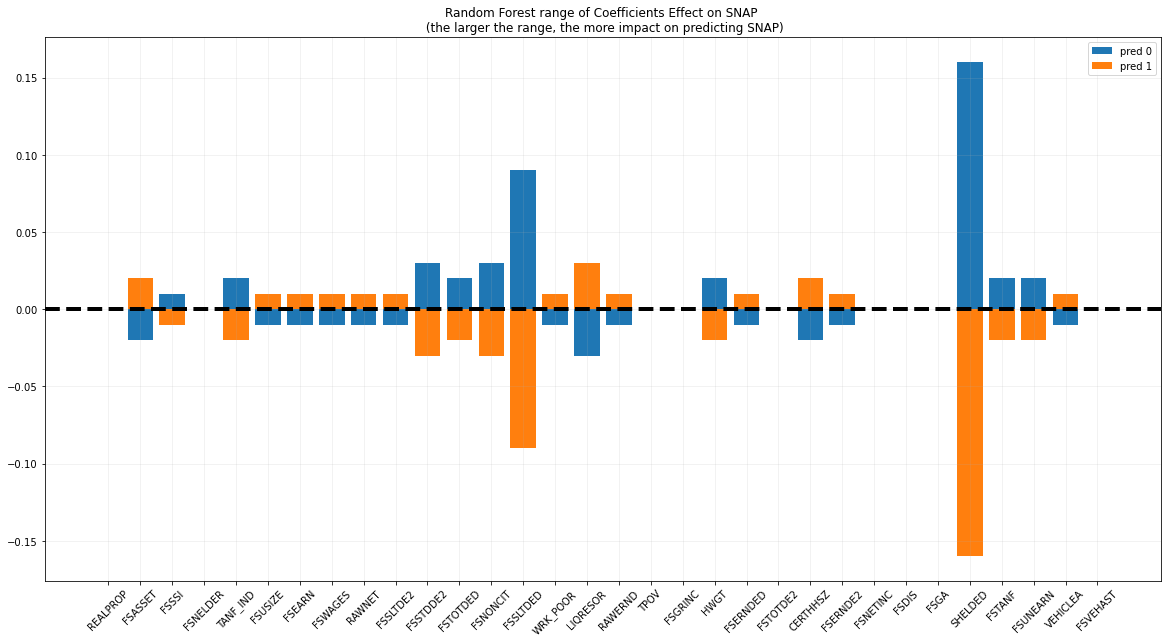

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Random Forest range of Coefficients Effect on SNAP \n (the larger the range, the more impact on predicting SNAP)')
plt.grid(zorder=0,alpha = 0.2)
xs = np.arange(len(labels))
ax.bar(xs,coef_df['pred_0'], label = 'pred 0')
ax.bar(xs,coef_df['pred_1'],label = 'pred 1')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.set_xticks(coef_df.index)
ax.set_xticklabels(coef_df['feature'],rotation = 45)
plt.legend()
plt.savefig('./images/rf_corr.png');

In [23]:
et = ExtraTreeClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'auto'],
       'max_leaf_nodes':[5,10]}
et_gs = GridSearchCV(et,param_grid=params)
et_gs.fit(X_train,y_train)
print(et_gs.best_score_)
et_gs.best_params_

0.8195572252245013


{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10}

In [24]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)
y_pred_train = bag.predict(X_train)
y_pred_test = bag.predict(X_test)
print(f'cross_val_train = {np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))}')
print(f'cross_val_test = {np.mean(cross_val_score(model,X_test,y_test,cv=4))}')
print(f'test_recall = {recall_score(y_test, y_pred_test)}')
print(f'test_precision = {precision_score(y_test, y_pred_test)}')

cross_val_train = 0.7269399707174231
cross_val_test = 0.7414675767918089
test_recall = 0.9448818897637795
test_precision = 0.9461235216819974


In [25]:
vote = VotingClassifier([
    ('rf',RandomForestClassifier(bootstrap=False,n_estimators=1000)),
    ('gb',GradientBoostingClassifier(max_depth=10,subsample=0.8)),
    ('bag',BaggingClassifier(n_estimators = 10))
])

In [26]:
vote.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     n_estimators=1000)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=10,
                                                         subsample=0.8)),
                             ('bag', BaggingClassifier())])

In [27]:
filename = 'final_model.sav'
pickle.dump(vote, open(filename, 'wb'))